JSON file saved at: D:\10 weeks Challenge\19.10.results.json


C:\Users\elpid\AppData\Local\Temp\ipykernel_16136\996204803.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_by_time = data.groupby('Time_Category').agg({'EDA': 'mean', 'Temp': 'mean'}).reset_index()


,Time_Category,Stress_Level
1,Morning,
2,Afternoon,
0,Night,

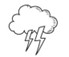
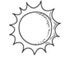
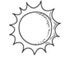

In [1]:
from PIL import Image
import base64
import pandas as pd
import numpy as np
import json
from io import BytesIO
from IPython.display import HTML


# Load data
df1 = pd.read_csv('EDA.csv')
df2 = pd.read_csv('TEMP.csv')

# Assuming 'Time' is in datetime format
df1['Formatted_Date'] = pd.to_datetime(df1['1697687697.000000'], unit='s')
time_increment = 250
df1['Formatted_Date'] += pd.to_timedelta(df1.index * time_increment, unit='ms')

# Extract relevant columns
data = pd.DataFrame({
    'Time': df1['Formatted_Date'],
    'EDA': df1['1697687697.000000'],
    'Temp': df2['1697687697.000000']
})

# Extract the hour from the 'Time' column
data['Hour'] = data['Time'].dt.hour

# Categorize time into morning, afternoon, and night based on the hour
bins = [-1, 5, 12, 18]
labels = ['Night', 'Morning', 'Afternoon']  # Adjusted labels to ensure uniqueness
data['Time_Category'] = pd.cut(data['Hour'], bins=bins, labels=labels, include_lowest=True)

# Calculate the average for 'EDA' and 'Temp' for each time category
average_by_time = data.groupby('Time_Category').agg({'EDA': 'mean', 'Temp': 'mean'}).reset_index()

# Define placeholder images (replace these with actual image paths)
very_stressed_image_path = '\\10 weeks Challenge\\Very_stressed.jpg'
not_stressed_image_path = '\\10 weeks Challenge\\Not_stressed.jpg'
stressed_image_path = '\\10 weeks Challenge\\Stressed.jpg'
maybe_stressed_image_path = '\\10 weeks Challenge\\Maybe_stressed.jpg'

very_stressed_image = Image.open(very_stressed_image_path)
not_stressed_image = Image.open(not_stressed_image_path)
stressed_image = Image.open(stressed_image_path)
maybe_stressed_image = Image.open(maybe_stressed_image_path)

def above_mean_matrix(average_by_time, data):
    # Calculate the mean of 'EDA' and 'Temp' for the entire day
    overall_mean_eda = data['EDA'].mean()
    overall_mean_temp = data['Temp'].mean()

    # Create a matrix of "Yes" or "No" based on whether the values are above the mean
    matrix = pd.DataFrame(index=average_by_time['Time_Category'], columns=['Above Mean EDA', 'Above Mean Temp'])

    matrix['Above Mean EDA'] = np.where(average_by_time['EDA'] > overall_mean_eda, 'Yes', 'No')
    matrix['Above Mean Temp'] = np.where(average_by_time['Temp'] > overall_mean_temp, 'Yes', 'No')

    return matrix

# Example usage:
matrix_result = above_mean_matrix(average_by_time, data)

def combine_stress_levels_with_images(matrix_result):
    stress_levels = []

    for index, row in matrix_result.iterrows():
        if row['Above Mean EDA'] == 'Yes' and row['Above Mean Temp'] == 'Yes':
            stress_levels.append(very_stressed_image)
        elif row['Above Mean EDA'] == 'No' and row['Above Mean Temp'] == 'No':
            stress_levels.append(not_stressed_image)
        elif row['Above Mean EDA'] == 'Yes' and row['Above Mean Temp'] == 'No':
            stress_levels.append(stressed_image)
        elif row['Above Mean EDA'] == 'No' and row['Above Mean Temp'] == 'Yes':
            stress_levels.append(maybe_stressed_image)

    stress_level_result = pd.DataFrame({'Time_Category': matrix_result.index, 'Stress_Level': stress_levels})

    # Convert images to base64 and embed them in HTML
    stress_level_result['Stress_Level'] = stress_level_result['Stress_Level'].apply(
        lambda img: f'<img src="data:image/png;base64,{image_to_base64(img)}" width="50">'
    )

    # Reorder the rows based on the desired order: Morning, Afternoon, Night
    stress_level_result = stress_level_result.reindex([1, 2, 0])

    return stress_level_result

def image_to_base64(image):
    buffered = BytesIO()
    image.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode("utf-8")

# Example usage:
stress_level_result_with_images = combine_stress_levels_with_images(matrix_result)

# Convert the DataFrame to a dictionary
stress_level_dict = stress_level_result_with_images.to_dict(orient='records')

# Convert images to base64 strings in the dictionary
for record in stress_level_dict:
    # Extract the base64-encoded image data
    base64_data = record['Stress_Level'].split(',')[1]
    
    # Ensure proper padding
    padding = '=' * ((4 - len(base64_data) % 4) % 4)
    base64_data += padding
    
    # Decode the base64 string and encode it back
    image_bytes = base64.b64decode(base64_data)
    record['Stress_Level'] = 'data:image/png;base64,' + base64.b64encode(image_bytes).decode('utf-8')

json_path = r'D:\10 weeks Challenge\19.10.results.json'
with open(json_path, 'w') as file:
    json.dump(stress_level_dict, file, indent=4)

print(f'JSON file saved at: {json_path}')
stress_level_result_with_images = combine_stress_levels_with_images(matrix_result)
display(HTML(stress_level_result_with_images.to_html(escape=False)))


